# Goals:

**1. Develop a natural language processor capable of predicting the COLOR of a magic card based on the rules text of that card.**


In [1]:
# imports and display options

import pandas as pd
import numpy as np
import math
from math import sqrt

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import unicodedata
import re
import nltk
from nltk.corpus import stopwords

import prepare as p
import explore as e
# import model as m

pd.set_option('display.max_colwidth', -1)

# Acquire

* Used file from previouse 
* A CSV, containing an up to date breakdown of each card that has been printed so far, was obtained from MTGJSON.com
* Each row represents a card or a version of a card
* The CSV was read into a pandas dataframe
* The original dataframe contained 51,430 rows and 73 columns

# Prepare

The following steps were taken to prepare the data:

1. Restricted dataframe to relevant columns
 
2. Restricted dataframe to rows containing cards that exist in physical form

3. Restricted dataframe to rows containing a value for 'text'

4. Restricted dataframe to rows with a single 'color identity' (see data dictionary Color)

5. Dropped all columns other than text and color

6. Renamed columns

7. Changed some of the symble represintations to words to make them machine readable

8. Applied basic cleaning to values in text by, lowercasing letters, converting to ASCII characters, removing non-letter characters, lemmatizeing the words, and removing stopwords

9. Dropped duplicate rows

10. Changed column order

11. Wrote prepared data to ‘mtgprep.csv’ for ease of access. Data consisted of 15380 rows and two columns.

12. Created a test and train group at a 20/80 split

## Data Dictionary:

* Magic: The Gathering
    * a collectable card game developed by Wizards of the Coast Inc. In a typical game, each player combines a selection of cards from their collection into his or her own deck, which they use to compete against other players. Thematically, players assume the roles of powerful mages fighting for supremacy. Cards in each players deck represent spells and other resources each player’s disposal. A game typically ends when all but one of the participating players is reduced to zero “life” or is otherwise eliminated from the game.

### Columns

* Color
    * Cards players use are divided into five different colors 
    * Each color is thematically distinct and the text of those cards reflects these differinces
    * The color of each card was determined by the color of mana symbols that appear on each card, also called its color identity
    * Cards with more than one color were excluded in hopes of giving the model a clearer distinction topredict on     <br />   

In [2]:
# prepare data 
df = p.get_preped_data()

#create test and train groups
train, test = p.split_data(df)

In [3]:
df.shape

(15380, 2)

# Explore

In [4]:
train.head()

,color,text
4849,Black,flying tap sacrifice phyrexian debaser target creature get minusandminus end turn
10892,Green,end turn target land becomes creature still land
10735,Black,choose creature type target creature get minusandminus end turn permanent chosen type control
14928,White,search library plain card target opponent control land may search library additional plain card reveal card put hand shuffle library
10354,White,long spectral guardian untapped noncreature artifact shroud target spell ability


In [5]:
e.get_distribution(train)

,n,percent
Black,2495,0.202780
Blue,2465,0.200341
White,2462,0.200098
Red,2460,0.199935
Green,2422,0.196847


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



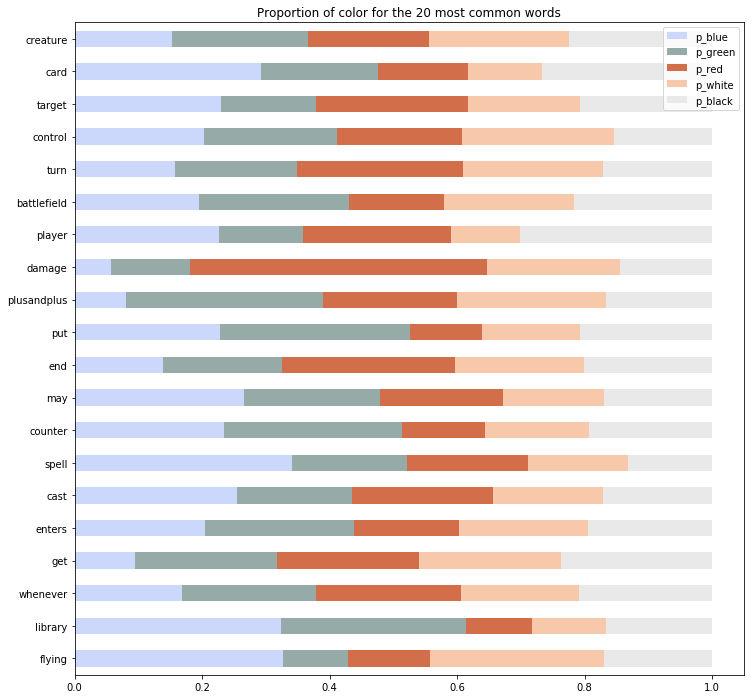

In [6]:
e.word_count(train)

In [7]:
print(train.text)

4849     flying tap sacrifice phyrexian debaser target creature get minusandminus end turn                                                                                          
10892    end turn target land becomes creature still land                                                                                                                           
10735    choose creature type target creature get minusandminus end turn permanent chosen type control                                                                              
14928    search library plain card target opponent control land may search library additional plain card reveal card put hand shuffle library                                       
10354    long spectral guardian untapped noncreature artifact shroud target spell ability                                                                                           
                                               ...                                             

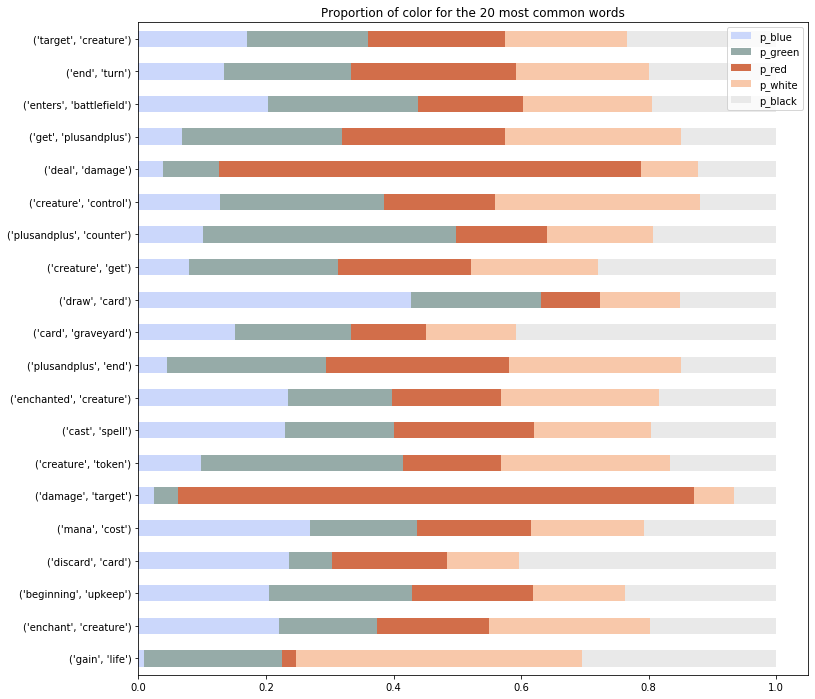

In [10]:
def  get_master_list(bigram_lists):
    
    master_bigram_list = []

    for lst in bigram_lists:
        for item in lst:
            master_bigram_list.append(item)
            
    return master_bigram_list

def get_ngram_value_counts(series,ngram):
    '''
    get a value count of ngrams from the text values of a pandas series 
    
    '''

    # convert text in text column values to a list of bigrams for the full text column and for values representing each color
    bigram_list = series.apply(lambda text: list(nltk.ngrams(text.split(),ngram)))


    # combine lists in series into one master list
    bigram_master_list = get_master_list(bigram_list)


    # convert each master list to a series then convert each of those tuples into strings
    bigram_series = pd.Series(bigram_master_list).apply(lambda tup: str(tup))


    # get value count for each string tuple in the series
    bigram_freq = bigram_series.value_counts()
    
    return bigram_freq

def get_word_distribution_graph(ngram):
    '''
    generate a graph showing the ratio of the 20 fost frequent ngrams by color
    '''
    
    all_freq = get_ngram_value_counts(train.text,ngram)
    blue_freq = get_ngram_value_counts(train.text[train.color=='Blue'],ngram)
    green_freq = get_ngram_value_counts(train.text[train.color=='Green'],ngram)
    red_freq = get_ngram_value_counts(train.text[train.color=='Red'],ngram)
    white_freq = get_ngram_value_counts(train.text[train.color=='White'],ngram)
    black_freq = get_ngram_value_counts(train.text[train.color=='Black'],ngram)
    
    # combine value counts into one pandas data frame                                        
    bigram_counts = (pd.concat([all_freq,blue_freq,green_freq,red_freq,white_freq,black_freq], axis=1, sort=True)
                    .set_axis(['all','blue','green','red','white','black'], axis=1, inplace=False)
                    .fillna(0)
                    .apply(lambda s: s.astype(int)))

    # display ratio of top 20 most frequent words by color
    (bigram_counts.assign(p_blue=bigram_counts.blue / bigram_counts['all'],
                            p_green=bigram_counts.green / bigram_counts['all'],
                            p_red=bigram_counts.red / bigram_counts['all'],
                            p_white=bigram_counts.white / bigram_counts['all'],
                            p_black=bigram_counts.black / bigram_counts['all'])
                    .sort_values(by='all')[['p_blue','p_green','p_red','p_white','p_black']]
                    .tail(20)
                    .plot.barh(stacked=True, color= ['#cbd7fb','#96aba8','#d26e4a','#f8c8aa','#e9e9e9'], figsize= (12,12)))

    plt.title('Proportion of color for the 20 most common words')
        
get_word_distribution_graph(2)


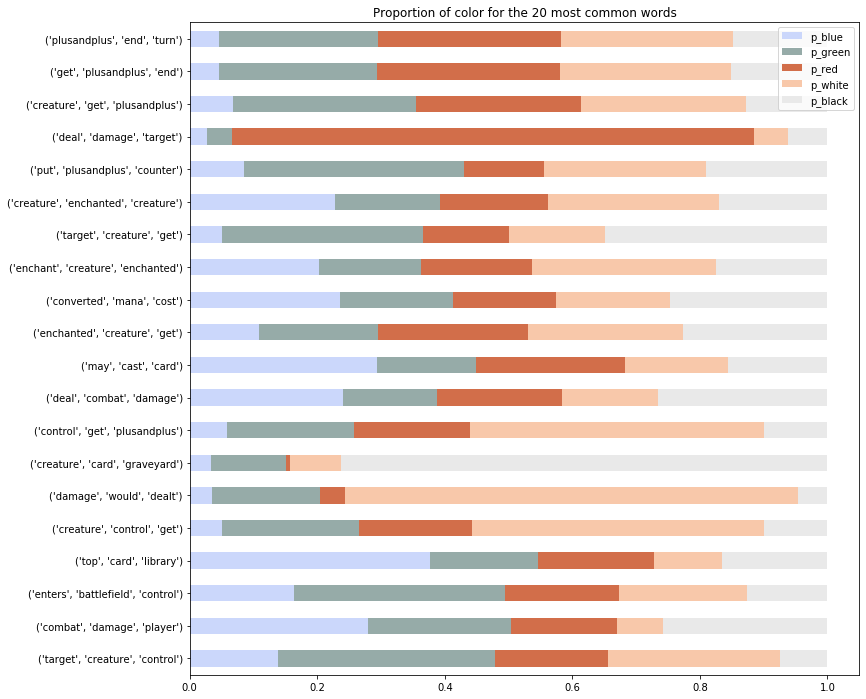

In [11]:
get_word_distribution_graph(3)

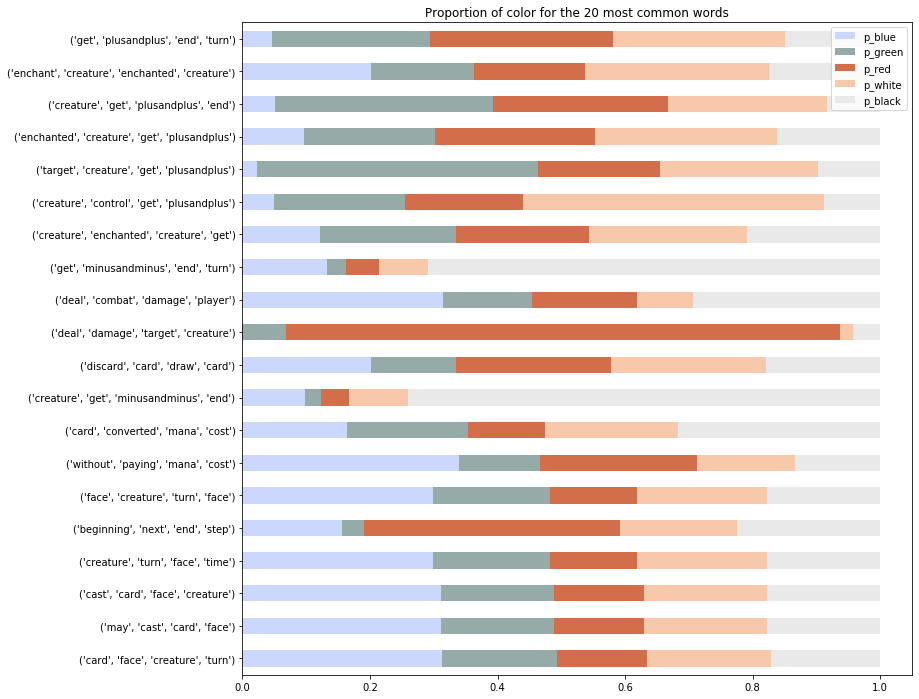

In [12]:
get_word_distribution_graph(4)

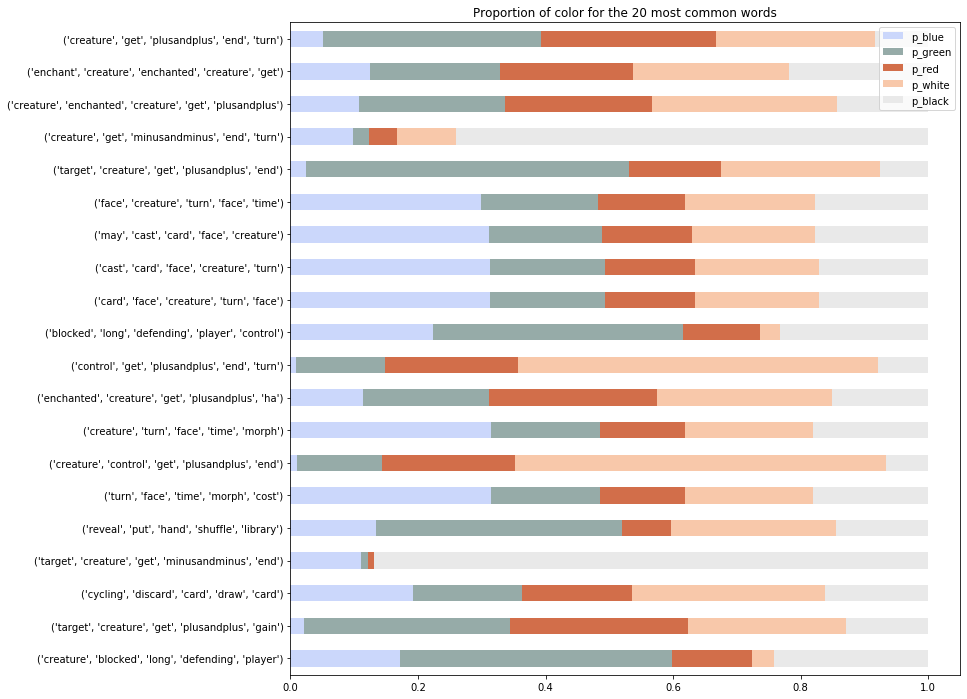

In [13]:
get_word_distribution_graph(5)

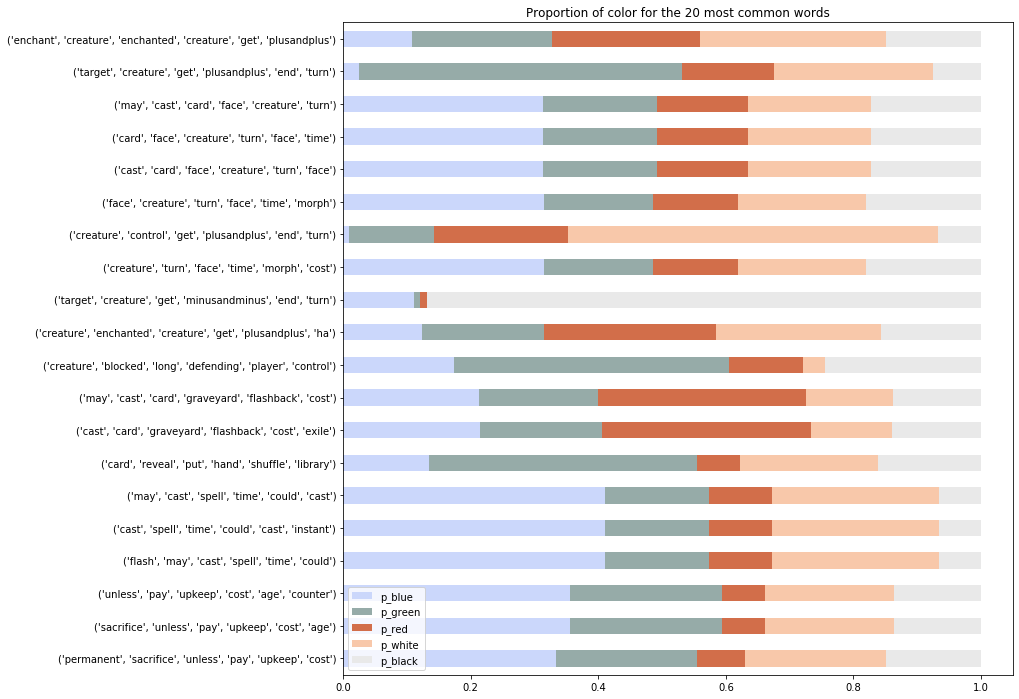

In [14]:
get_word_distribution_graph(6)

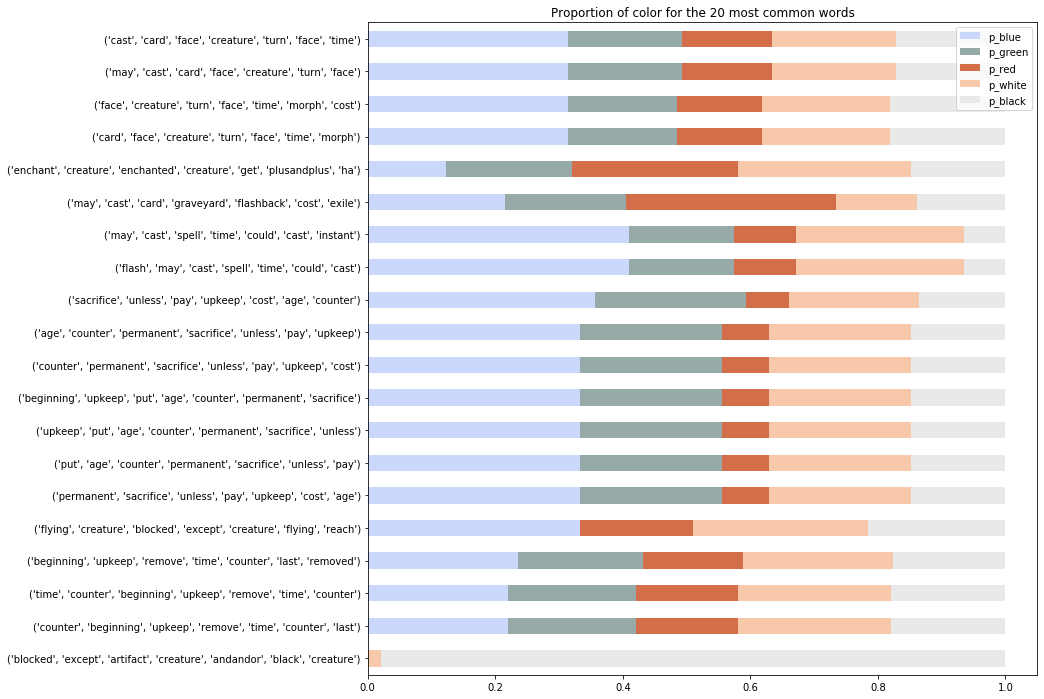

In [15]:
get_word_distribution_graph(7)

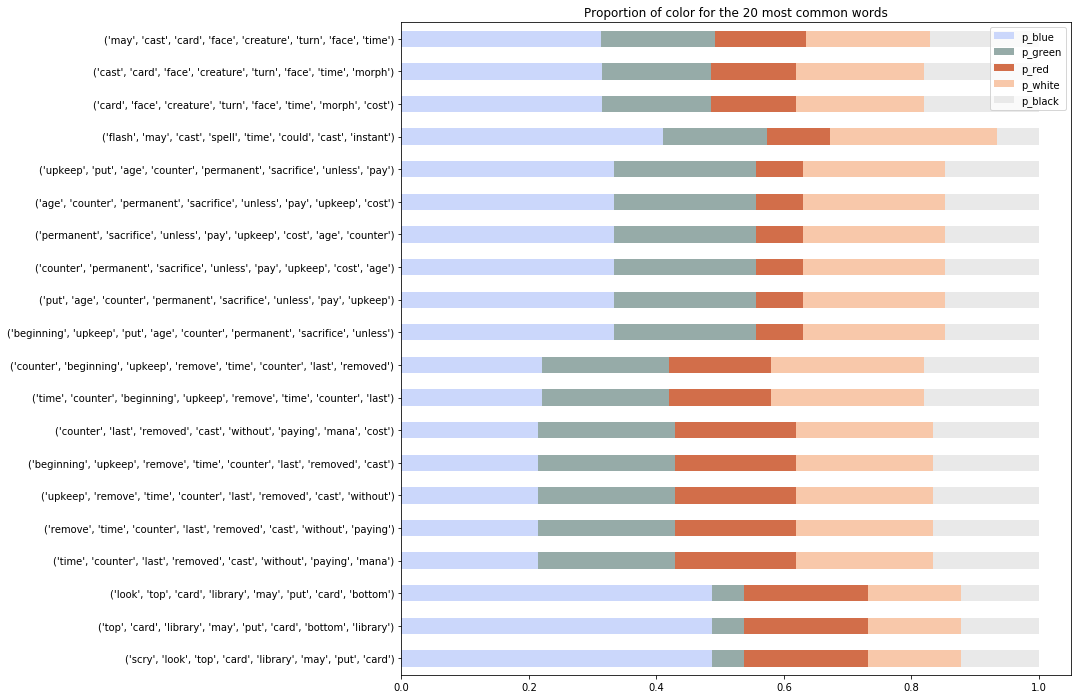

In [16]:
get_word_distribution_graph(8)

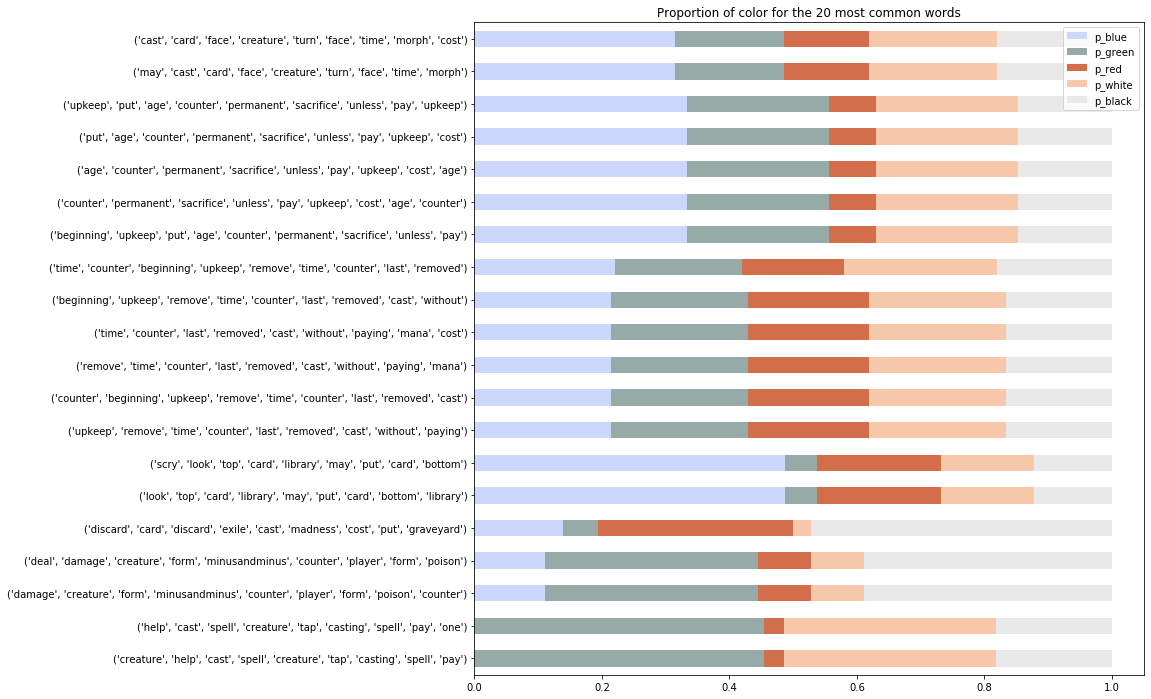

In [17]:
get_word_distribution_graph(9)

In [ ]:
train.text

In [ ]:
def  get_master_list(bigram_lists):
    
    master_bigram_list = []

    for lst in bigram_lists:
        for item in lst:
            master_bigram_list.append(item)
            
    return master_bigram_list

# convert text in text column to a list of bigrams for the full text column and for values representing each color
all_bigram_list = df.text.apply(lambda text: list(nltk.ngrams(text.split(),2)))
blue_bigram_list = df[df.color == "Blue"].text.apply(lambda text: list(nltk.ngrams(text.split(),2)))
green_bigram_list = df[df.color == "Green"].text.apply(lambda text: list(nltk.ngrams(text.split(),2)))
red_bigram_list = df[df.color == "Red"].text.apply(lambda text: list(nltk.ngrams(text.split(),2)))
white_bigram_list = df[df.color == "White"].text.apply(lambda text: list(nltk.ngrams(text.split(),2)))
black_bigram_list = df[df.color == "Black"].text.apply(lambda text: list(nltk.ngrams(text.split(),2)))

# combine lists in series into one master list
all_bigram_master_list = get_master_list(all_bigram_list)
blue_bigram_master_list = get_master_list(blue_bigram_list)
green_bigram_master_list = get_master_list(green_bigram_list)
red_bigram_master_list = get_master_list(red_bigram_list)
white_bigram_master_list = get_master_list(white_bigram_list)
black_bigram_master_list = get_master_list(black_bigram_list)

# convert each master list to a series then convert each of those tuples into strings
all_bigram_series = pd.Series(all_bigram_master_list).apply(lambda tup: str(tup))
blue_bigram_series = pd.Series(blue_bigram_master_list).apply(lambda tup: str(tup))
green_bigram_series = pd.Series(green_bigram_master_list).apply(lambda tup: str(tup))
red_bigram_series = pd.Series(red_bigram_master_list).apply(lambda tup: str(tup))
white_bigram_series = pd.Series(white_bigram_master_list).apply(lambda tup: str(tup))
black_bigram_series = pd.Series(black_bigram_master_list).apply(lambda tup: str(tup))

# get value count for each string tuple in the series
all_bigram_freq = all_bigram_series.value_counts()
blue_bigram_freq = blue_bigram_series.value_counts()
green_bigram_freq = green_bigram_series.value_counts()
red_bigram_freq = red_bigram_series.value_counts()
white_bigram_freq = white_bigram_series.value_counts()
black_bigram_freq = black_bigram_series.value_counts()

# combine value counts into one pandas data frame                                        
bigram_counts = (pd.concat([all_bigram_freq,blue_bigram_freq,green_bigram_freq,red_bigram_freq,white_bigram_freq,black_bigram_freq], axis=1, sort=True)
                .set_axis(['all','blue','green','red','white','black'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

# display ratio of top 20 most frequent words by color
(bigram_counts.assign(p_blue=bigram_counts.blue / bigram_counts['all'],
                        p_green=bigram_counts.green / bigram_counts['all'],
                        p_red=bigram_counts.red / bigram_counts['all'],
                        p_white=bigram_counts.white / bigram_counts['all'],
                        p_black=bigram_counts.black / bigram_counts['all'])
                .sort_values(by='all')[['p_blue','p_green','p_red','p_white','p_black']]
                .tail(20)
                .plot.barh(stacked=True, color= ['#cbd7fb','#96aba8','#d26e4a','#f8c8aa','#e9e9e9'], figsize= (12,12)))

plt.title('Proportion of color for the 20 most common ngrams')

In [ ]:
def  get_master_list(bigram_lists):
    
    master_bigram_list = []

    for lst in bigram_lists:
        for item in lst:
            master_bigram_list.append(item)
            
    return master_bigram_list

# convert text in text column to a list of bigrams for the full text column and for values representing each color
all_bigram_list = df.text.apply(lambda text: list(nltk.ngrams(text.split(),3)))
blue_bigram_list = df[df.color == "Blue"].text.apply(lambda text: list(nltk.ngrams(text.split(),3)))
green_bigram_list = df[df.color == "Green"].text.apply(lambda text: list(nltk.ngrams(text.split(),3)))
red_bigram_list = df[df.color == "Red"].text.apply(lambda text: list(nltk.ngrams(text.split(),3)))
white_bigram_list = df[df.color == "White"].text.apply(lambda text: list(nltk.ngrams(text.split(),3)))
black_bigram_list = df[df.color == "Black"].text.apply(lambda text: list(nltk.ngrams(text.split(),3)))

# combine lists in series into one master list
all_bigram_master_list = get_master_list(all_bigram_list)
blue_bigram_master_list = get_master_list(blue_bigram_list)
green_bigram_master_list = get_master_list(green_bigram_list)
red_bigram_master_list = get_master_list(red_bigram_list)
white_bigram_master_list = get_master_list(white_bigram_list)
black_bigram_master_list = get_master_list(black_bigram_list)

# convert each master list to a series then convert each of those tuples into strings
all_bigram_series = pd.Series(all_bigram_master_list).apply(lambda tup: str(tup))
blue_bigram_series = pd.Series(blue_bigram_master_list).apply(lambda tup: str(tup))
green_bigram_series = pd.Series(green_bigram_master_list).apply(lambda tup: str(tup))
red_bigram_series = pd.Series(red_bigram_master_list).apply(lambda tup: str(tup))
white_bigram_series = pd.Series(white_bigram_master_list).apply(lambda tup: str(tup))
black_bigram_series = pd.Series(black_bigram_master_list).apply(lambda tup: str(tup))

# get value count for each string tuple in the series
all_bigram_freq = all_bigram_series.value_counts()
blue_bigram_freq = blue_bigram_series.value_counts()
green_bigram_freq = green_bigram_series.value_counts()
red_bigram_freq = red_bigram_series.value_counts()
white_bigram_freq = white_bigram_series.value_counts()
black_bigram_freq = black_bigram_series.value_counts()

# combine value counts into one pandas data frame                                        
bigram_counts = (pd.concat([all_bigram_freq,blue_bigram_freq,green_bigram_freq,red_bigram_freq,white_bigram_freq,black_bigram_freq], axis=1, sort=True)
                .set_axis(['all','blue','green','red','white','black'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

# display ratio of top 20 most frequent words by color
(bigram_counts.assign(p_blue=bigram_counts.blue / bigram_counts['all'],
                        p_green=bigram_counts.green / bigram_counts['all'],
                        p_red=bigram_counts.red / bigram_counts['all'],
                        p_white=bigram_counts.white / bigram_counts['all'],
                        p_black=bigram_counts.black / bigram_counts['all'])
                .sort_values(by='all')[['p_blue','p_green','p_red','p_white','p_black']]
                .tail(20)
                .plot.barh(stacked=True, color= ['#cbd7fb','#96aba8','#d26e4a','#f8c8aa','#e9e9e9'], figsize= (12,12)))

plt.title('Proportion of color for the 20 most common words')
        


In [ ]:
def  get_master_list(bigram_lists):
    
    master_bigram_list = []

    for lst in bigram_lists:
        for item in lst:
            master_bigram_list.append(item)
            
    return master_bigram_list

# convert text in text column to a list of bigrams for the full text column and for values representing each color
all_bigram_list = df.text.apply(lambda text: list(nltk.ngrams(text.split(),4)))
blue_bigram_list = df[df.color == "Blue"].text.apply(lambda text: list(nltk.ngrams(text.split(),4)))
green_bigram_list = df[df.color == "Green"].text.apply(lambda text: list(nltk.ngrams(text.split(),4)))
red_bigram_list = df[df.color == "Red"].text.apply(lambda text: list(nltk.ngrams(text.split(),4)))
white_bigram_list = df[df.color == "White"].text.apply(lambda text: list(nltk.ngrams(text.split(),4)))
black_bigram_list = df[df.color == "Black"].text.apply(lambda text: list(nltk.ngrams(text.split(),4)))

# combine lists in series into one master list
all_bigram_master_list = get_master_list(all_bigram_list)
blue_bigram_master_list = get_master_list(blue_bigram_list)
green_bigram_master_list = get_master_list(green_bigram_list)
red_bigram_master_list = get_master_list(red_bigram_list)
white_bigram_master_list = get_master_list(white_bigram_list)
black_bigram_master_list = get_master_list(black_bigram_list)

# convert each master list to a series then convert each of those tuples into strings
all_bigram_series = pd.Series(all_bigram_master_list).apply(lambda tup: str(tup))
blue_bigram_series = pd.Series(blue_bigram_master_list).apply(lambda tup: str(tup))
green_bigram_series = pd.Series(green_bigram_master_list).apply(lambda tup: str(tup))
red_bigram_series = pd.Series(red_bigram_master_list).apply(lambda tup: str(tup))
white_bigram_series = pd.Series(white_bigram_master_list).apply(lambda tup: str(tup))
black_bigram_series = pd.Series(black_bigram_master_list).apply(lambda tup: str(tup))

# get value count for each string tuple in the series
all_bigram_freq = all_bigram_series.value_counts()
blue_bigram_freq = blue_bigram_series.value_counts()
green_bigram_freq = green_bigram_series.value_counts()
red_bigram_freq = red_bigram_series.value_counts()
white_bigram_freq = white_bigram_series.value_counts()
black_bigram_freq = black_bigram_series.value_counts()

# combine value counts into one pandas data frame                                        
bigram_counts = (pd.concat([all_bigram_freq,blue_bigram_freq,green_bigram_freq,red_bigram_freq,white_bigram_freq,black_bigram_freq], axis=1, sort=True)
                .set_axis(['all','blue','green','red','white','black'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

# display ratio of top 20 most frequent words by color
(bigram_counts.assign(p_blue=bigram_counts.blue / bigram_counts['all'],
                        p_green=bigram_counts.green / bigram_counts['all'],
                        p_red=bigram_counts.red / bigram_counts['all'],
                        p_white=bigram_counts.white / bigram_counts['all'],
                        p_black=bigram_counts.black / bigram_counts['all'])
                .sort_values(by='all')[['p_blue','p_green','p_red','p_white','p_black']]
                .tail(20)
                .plot.barh(stacked=True, color= ['#cbd7fb','#96aba8','#d26e4a','#f8c8aa','#e9e9e9'], figsize= (12,12)))

plt.title('Proportion of color for the 20 most common words')
        

In [ ]:
def  get_master_list(bigram_lists):
    
    master_bigram_list = []

    for lst in bigram_lists:
        for item in lst:
            master_bigram_list.append(item)
            
    return master_bigram_list

def get_ngrams(series,ngram):
    '''
    get a value count of ngrams from the text values of a pandas series 
    
    '''

    # convert text in text column values to a list of bigrams for the full text column and for values representing each color
    bigram_list = series.apply(lambda text: list(nltk.ngrams(text.split(),ngram)))


    # combine lists in series into one master list
    bigram_master_list = get_master_list(all_bigram_list)


    # convert each master list to a series then convert each of those tuples into strings
    bigram_series = pd.Series(all_bigram_master_list).apply(lambda tup: str(tup))


    # get value count for each string tuple in the series
    bigram_freq = all_bigram_series.value_counts()
    
    return bigram_freq

get_ngrams(train.text,2)
